### Veri Setinin İçeri Aktarılması

#### Kütüphaneler

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import os # Python sistem ilişkileri
import cv2 # Görüntü İşleme
import pandas as pd # Frame İşlemleri
import matplotlib.pyplot as plt # Görüntüleme ve grafik oluşturma işlemleri
import numpy as np # Dizi işlemleri

#### Veri Setinin Metadatasını İçeri Aktarma
Veriseti bir csv dosyası içeriside her resim dosyasının yoluna karşılık gelen id, kanser türü, yaş, cinsiyet, kanserli hücre konumu verilerini içerir. Bir bu eğitimde sadece görsel yollarından resimleri içeri aktaracağız(X) ve 'dx' kolununda bulunan her satırın kanser türünü(Y) alacağız. Görselleri ileride içeri aktaracağız.

In [35]:
os.getcwd()

'/content'

In [36]:
dataset_metadata = pd.read_csv("./drive/MyDrive/odev_last/dataset/HAM10000_metadata.csv")
dataset_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [37]:
# Metadata içerisinden başlangıç(X) ve hedef(Y) değerlerimizi aldık.
y = dataset_metadata["dx"]
img_names = dataset_metadata["image_id"]

#### Veri Setinin Dağılımları

Kanser Türü Dağılımları
 {'nv': 6705, 'mel': 1113, 'bkl': 1099, 'bcc': 514, 'akiec': 327, 'vasc': 142, 'df': 115}


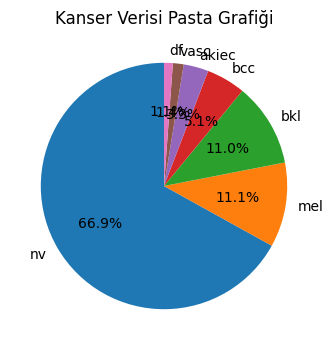

In [38]:
# Hedef verileri saydırıp bir sözlüğün içerisine alıyoruz.
y_dict = y.value_counts().to_dict()
print("Kanser Türü Dağılımları\n",y_dict)

# Pasta grafiğini
plt.figure(figsize=(4, 4))  # Grafiğin boyutunu ayarla (isteğe bağlı)

# 'autopct' parametresi yüzdelik değerlerini ekler,
# 'startangle' parametresi başlangıç açısını ayarlar
plt.pie(y_dict.values(), labels=y_dict.keys(), autopct='%1.1f%%', startangle=90)


plt.title('Kanser Verisi Pasta Grafiği')
plt.show()

#### Verilerin modele uygun hale getirilmesi


x ve y verilerini numpy(np) dizisine çevirerek vektörel haline getirdik ve bu sayede numpy işlemleri bu veriler üzerinde kullanılabilir.
skiticlearn kütüphanesi içerisindeki train_test_split metodu ile eşlenik verileri eğitim ve testte kullılmak üzere 2 parçaya böldük. Bölme oranın 0.33 belirledik.

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
y = np.array(y)
img_names = np.array(img_names)

img_names_train, img_names_test, Y_train, Y_test = train_test_split(img_names, y, test_size=0.33, random_state=42)
print("Eğitimde X boyutu :",img_names_train.shape)
print("Eğitimde Y boyutu :",Y_train.shape)
print("Testte X boyutu :",img_names_test.shape)
print("Testte Y boyutu :",Y_test.shape)

Eğitimde X boyutu : (6710,)
Eğitimde Y boyutu : (6710,)
Testte X boyutu : (3305,)
Testte Y boyutu : (3305,)


7 türdeki kanser hücrelerini kategorik veriden sayısal veriye dönüştürmek için skiticlearnden OneHotEncoder kullanarak her kategoriyi yalnızca bir adet 1 ve diğer özellikleri 0 olacak şekilde vektörlere dönüştürdük.

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories=[['bkl', 'nv', 'vasc', 'mel', 'akiec', 'df', 'bcc']])

Y_train = encoder.fit_transform(np.reshape(Y_train,newshape=(-1,1))).toarray()
Y_test = encoder.fit_transform(np.reshape(Y_test,newshape=(-1,1))).toarray()

feature_names = encoder.get_feature_names_out(input_features=["tür_kanser"])

pd.DataFrame(Y_train, columns=feature_names).head()# İlk beş satırı göster


,tür_kanser_bkl,tür_kanser_nv,tür_kanser_vasc,tür_kanser_mel,tür_kanser_akiec,tür_kanser_df,tür_kanser_bcc
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Modele vermek üzere resimlerimizin boyutlarını istediğimiz boyuta şekillendiriyoruz.
Daha az işlem hacmi için orjinalinden daha küçük boyutlu resimler tercih ettik

Önceden image_names olarak aldığımız ve ayırdığımız resim yollarını kullanarak resimleri içeri aktarıyoruz.

In [42]:
cnn_image_input_size = (120,150,3)

In [11]:
os.chdir("./drive/MyDrive/odev_last/dataset/HAM10000_images")

In [31]:
os.chdir("..")

In [51]:
os.getcwd()

'/content'

In [52]:
os.chdir("./gdrive/MyDrive/odev_last/dataset/HAM10000_images")

In [50]:
!unzip "./gdrive/My Drive/odev_last.zip" -d "/content"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029337.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029338.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029339.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029340.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029341.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029342.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029343.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029344.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029345.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029346.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029347.jpg  
  inflating: /content/odev_last/dataset/HAM10000_images/ISIC_0029348.jpg  
  inflating: /content/odev_last/dataset/HAM10000_imag

In [53]:
X_train = []
i = 0
for im_name in img_names_train:
    im = cv2.imread(f"./{im_name}.jpg") # İçeri aktarma
    i+=1
    print(i," ",im_name)
    im = cv2.resize(im,dsize=(cnn_image_input_size[1],cnn_image_input_size[0])) #Yeniden boyutlandırma
    X_train.append(im) #Verisetine ekleme

X_test =  []
for im_name in img_names_test:
    im = cv2.imread(f"./{im_name}.jpg")
    print(i," ",im_name)
    i+=1
    im = cv2.resize(im,dsize=(cnn_image_input_size[1],cnn_image_input_size[0]))
    X_test.append(im)

#X'lerin vektörizasyonunu sağladık
X_train = np.array(X_train)
X_test = np.array(X_test)

print("X:",X_train.shape,"Y:",Y_train.shape)
print("X:",X_test.shape,"Y:",Y_test.shape)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
5018   ISIC_0025630
5019   ISIC_0026684
5020   ISIC_0030886
5021   ISIC_0032285
5022   ISIC_0033846
5023   ISIC_0032027
5024   ISIC_0030844
5025   ISIC_0028969
5026   ISIC_0024923
5027   ISIC_0032030
5028   ISIC_0028464
5029   ISIC_0030167
5030   ISIC_0033927
5031   ISIC_0026910
5032   ISIC_0027189
5033   ISIC_0029166
5034   ISIC_0025133
5035   ISIC_0027238
5036   ISIC_0028821
5037   ISIC_0026720
5038   ISIC_0026950
5039   ISIC_0028681
5040   ISIC_0032714
5041   ISIC_0031392
5042   ISIC_0028133
5043   ISIC_0032981
5044   ISIC_0030050
5045   ISIC_0033890
5046   ISIC_0028100
5047   ISIC_0029336
5048   ISIC_0031176
5049   ISIC_0024439
5050   ISIC_0031842
5051   ISIC_0033340
5052   ISIC_0026793
5053   ISIC_0029030
5054   ISIC_0027909
5055   ISIC_0028830
5056   ISIC_0031058
5057   ISIC_0028870
5058   ISIC_0032254
5059   ISIC_0030361
5060   ISIC_0025499
5061   ISIC_0031131
5062   ISIC_0029882
5063   ISIC_0028277
5064   ISIC_0027142
5065   ISIC_0

In [ ]:
os.chdir("..")
os.chdir("..")

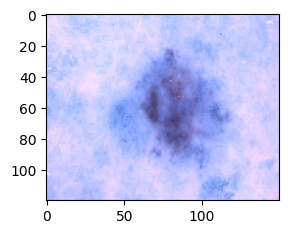

In [54]:
plt.figure(figsize=(3,3)) # Plot boyutu

#İçeri aktardığımız görseller(X) verilerinden rastgele birini gösterdik
plt.imshow(X_train[np.random.randint(0,high=X_train.shape[0])])
plt.show()

#### Evrişimli Sinir Ağı(CNN) Modeli

Her oluşturulan model ve ve modeli oluşturan parçacıklarını durumunu bir txt ve bir excel
dosyasına kaydetmek için "data" sözlüğünü oluşturuyoruz.

In [55]:
excel_file_path = './results/result_history.xlsx'
txt_file_path = "./results/result_history.txt"

excel_data = {
    "version": [],
    "epochs" : [],
    "conv1": [],
    "conv2": [],
    "conv3": [],
    "dropout1": [],
    "dropout2": [],
    "dense1": [],
    "dense2": [],
    "test_acc": [],
    "test_loss": [],
    "f1_score" : [],
    "relevance": [],
    "precision" : [],
    "recall" : [],



}


CNN eğitimi için tensorflow kütüphanesini kullanıyoruz.

In [56]:
from tensorflow.keras.layers import Dense,Dropout,Input,Conv2D,MaxPooling2D,Flatten
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import f1_score
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.metrics import Recall,Precision
import keras.backend as K

In [57]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


Parçacıkların değerlerine göre CNN Modeli oluşturan fonksiyon

In [58]:
def build_and_fit_model(model_version,epochs,train_x,test_x,train_y,test_y,conv1,conv2,conv3,dense1,dense2,dropout1,dropout2):

    if(dropout1>100):
        dropout1 = dropout1 / 10
    if(dropout2>100):
        droput1 = dropout2 / 10
    # Model Tanımlanması
    model = Sequential()

    model.add(Input(shape=cnn_image_input_size))
    model.add(Conv2D(conv1,kernel_size=(3,3),activation=LeakyReLU(alpha=0.3),))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(conv2,kernel_size=(5,5),activation=LeakyReLU(alpha=0.3),))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(conv3,kernel_size=(3,3),activation=LeakyReLU(alpha=0.3),))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(dense1))
    model.add(Dropout(dropout1/100))
    model.add(Dense(dense2))
    model.add(Dropout(dropout2/100))
    model.add(Dense(7,activation="softmax"))

    model.summary()

    # Modeli derleme
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=[Precision(),Recall(),'accuracy',get_f1])

    # Modeli eğitme
    history = model.fit(x=train_x,y=train_y,epochs=epochs)

    # Model kaydetme
    model.save(f"./results/models/model_{model_version}.h5")

    # Model test etme
    metric_results = model.evaluate(test_x, test_y)

    #precision
    precision = metric_results[0]

    #recall
    recall = metric_results[1]

    #accuracy
    test_acc = metric_results[2]

    #f1 skoru
    f1 = metric_results[3]

    #
    relevance = test_acc * recall * precision
    ##sonuçları txt dosyasına kaydetme
    with open(txt_file_path,"a") as file:
        file.write(f"\nversion:,{model_version},conv:,{conv1},{conv2},{conv3},dense:,{dense1},{dense2},dropout:,{dropout1},{dropout2},precision:,{precision},recall:,{recall},accuracy:,{test_acc},f1:,{f1}")
        file.close()

    ##sonuçları excel dosyasına kaydetme
    excel_data["version"].append(model_version)
    excel_data["epochs"].append(epochs)
    excel_data["conv1"].append(conv1)
    excel_data["conv2"].append(conv2)
    excel_data["conv3"].append(conv3)

    excel_data["dropout1"].append(dropout1)
    excel_data["dropout2"].append(dropout2)
    excel_data["dense1"].append(dense1)
    excel_data["dense2"].append(dense2)

    excel_data["test_acc"].append(test_acc)
    excel_data["f1_score"].append(f1)

    excel_data["precision"].append(precision)
    excel_data["recall"].append(recall)
    excel_data["relevance"].append(relevance)
    return relevance

#### Parçacık Sürü Optimizasyonu(PSO) Modeli

PSO içerisinde pbest değerini parçacığın tüm zamanlardaki mevcut en az değeri, gbest değerini ise her parçacık için tanımlayıp Evrişimli Sinir Ağı(CNN) katmanının en yüksek doğruluklu tahmin veren versiyonundaki parçacık değeri olarak belirledik. Doğal olarak pbest'in daha az değerlere gbest'inse genellikle daha yüksek değerlere yakınsamasını bekliyoruz.

In [59]:
from tqdm import tqdm # Eğitim sürecini daha güzel görselleştirmek için
from IPython.display import clear_output # Notebook'taki çıktıları sürekli olarak yenileyerek daha iyi bir görünüm sağlamak
import time # zamansal süreçleri daha iyi ele alabılmak için
import math # gömülü gelen python matematik kütüphanesi
import random

Parçacık

In [60]:
class particle:
    def __init__(self,x,c1,c2,gbest,particle_id):
        self.x = x # parçacığın konumu
        self.v = 0 # parçacığın değişim hızı
        self.pbest = x # parçacığın pbest değeri
        self.gbest = gbest # parçacığın gbest değeri(sürü değiştirir)
        self.c1 = c1 # parçacığın sabitleri
        self.c2 = c2
        self.particle_id = particle_id # parçacığın kolay takip edilebilemesi için id(gerekli değildir)

    # Parçacığın değişim hızını ölçmek
    def calculate_new_speed(self):
        self.v = self.v  +  self.c1 * random.uniform(0,2) * (self.pbest - self.x)  +  self.c2 *random.uniform(0,2) * (self.gbest - self.x)
        print(f"parçacık-{self.particle_id}  değişim hızı : {self.v}")

    # parçacığın yeni değerini ölçmek
    def calculate_new_x(self):
        self.x = self.x + self.v

        # eğer mevcut x pbest'ten düşükse pbest artık x'tir
        if(abs(self.x) < abs(self.pbest)):
            self.pbest = self.x
        print(f"parçacık-{self.particle_id}  x : {self.x} ")
        print(f"parçacık-{self.particle_id}  pbest : {self.pbest}")

    def calculate(self):
        self.calculate_new_speed()
        self.calculate_new_x()

Parçacık Sürüsü

In [61]:

class Particles:
    def __init__(self,c1,c2,pso_epochs,cnn_epochs):
        self.c1 = c1 # sabitler
        self.c2 = c2 #
        self.pso_epochs = pso_epochs # pso'nun kaç çağ ilerleyeceği
        self.cnn_epochs = cnn_epochs # cnn'in kaç çağ ilerleyeceği

        self.init_particle_gbests = 100 # ilk baştaki gbest değerleri(her parçacık için)
        self.model_acc_best = 0 # mevcut en yüksek doğruluklu tahmin oranı(gbestler yenilenirken kullanılır)

    # Parçacıkları oluştur
    def define_particles(self,particle_list):

        particles = []
        for i in range(len(particle_list)):
            particles.append(particle(particle_list[i],self.c1,self.c2,self.init_particle_gbests,particle_list[i]))
        self.particles = particles

    # Her bir çağın ilerleme süreci
    def epoch(self,version):

        # CNN ağındaki parametreler her zaman 0 dan büyük olmalıdır
        # Bu yüzden mutlak değer(abs) ve yukarı yuvarlama(ceil) işlemleri uygulayarak
        # modeldeki parametreli 0'dan büyük tutuyoruz.
        p1 = math.ceil(abs(self.particles[0].x))
        p2 = math.ceil(abs(self.particles[1].x))
        p3 = math.ceil(abs(self.particles[2].x))
        p4 = math.ceil(abs(self.particles[3].x))
        p5 = math.ceil(abs(self.particles[4].x))
        p6 = math.ceil(abs(self.particles[5].x))
        p7 = math.ceil(abs(self.particles[6].x))

        # Mevcut parçacıklarla modeli eğitiyoruz
        relevance= build_and_fit_model(version,self.cnn_epochs,X_train,X_test,Y_train,Y_test,p1,p2,p3,p4,p5,p6,p7)

        # her parçacık için yeni x,v,pbest değerlerini hesaplatıyoruz.
        for particle in self.particles:
            particle.calculate()

        # her parçacık için yeni gbest değerlerini hesaplatıyoruz.
        self.calculate_new_gbests(relevance)

    # Yeni doğruluk oranına göre gbest değerlerini hesaplamak
    def calculate_new_gbests(self,acc):
        if(acc> self.model_acc_best):
            for particle in self.particles:
                particle.gbest = particle.x

        for particle in self.particles:
            print(f"particle-{particle.particle_id}  gbest:",particle.gbest)

    # Pso eğitim fonksiyonu, belirlenen "epochs" kere eğitiyoruz.
    def fit(self):
        for i in tqdm(range(self.pso_epochs)):
            self.epoch(i)
            time.sleep(0.1)
            clear_output(wait=True)

#### Model eğitimi

In [62]:
particles = Particles(0.1,0.2,10,100)

In [63]:
particles.define_particles([52,50,49,30,32,10,11])

In [64]:
particles.fit()

100%|██████████| 10/10 [2:55:28<00:00, 1052.90s/it]


In [67]:
print(excel_data)

{'version': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'epochs': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100], 'conv1': [52, 69, 85, 100, 112, 122, 126, 127, 120, 103], 'conv2': [50, 70, 88, 104, 110, 110, 106, 95, 76, 54], 'conv3': [49, 67, 84, 96, 101, 106, 99, 85, 71, 52], 'dropout1': [10, 32, 52, 67, 81, 82, 81, 75, 58, 37], 'dropout2': [11, 32, 51, 63, 72, 75, 74, 65, 50, 33], 'dense1': [30, 58, 81, 97, 107, 116, 115, 102, 79, 48], 'dense2': [32, 36, 38, 40, 42, 41, 40, 39, 37, 34], 'test_acc': [0.6577911972999573, 0.5809379816055298, 0.6181542873382568, 0.6520423889160156, 0.6644477844238281, 0.6647503972053528, 0.6638426780700684, 0.6571860909461975, 0.5945537090301514, 0.6435703635215759], 'test_loss': [], 'f1_score': [0.6638426780700684, 0.6641452312469482, 0.6989409923553467, 0.6653555035591125, 0.6659606695175171, 0.6647503972053528, 0.6638426780700684, 0.6717095375061035, 0.7028744220733643, 0.6720120906829834], 'relevance': [1.3626877970362357, 0.48841966690575905, 0.4384256390

Sözlükteki sonuçları excele kaydet

In [83]:
excel_data["test_acc"]

[0.6577911972999573,
 0.5809379816055298,
 0.6181542873382568,
 0.6520423889160156,
 0.6644477844238281,
 0.6647503972053528,
 0.6638426780700684,
 0.6571860909461975,
 0.5945537090301514,
 0.6435703635215759]

In [81]:
with pd.ExcelWriter(excel_file_path, mode='w') as writer:
    res_df = pd.DataFrame(excel_data)
    res_df.to_excel(writer, index=False, header=False, sheet_name="sheet4")